In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [59]:
IMAGES_PATH = Path() /"images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader setup

## commission scheme

In [5]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

In [6]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [114]:
class SignalData(PandasData):

    cols = OHLCV + [strat] #modify this for different classifier

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [88]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and prediction value in the series
        self.data_prediction = self.datas[0].dummy_clf #modify this
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        #print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_prediction > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_prediction < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

### Create and configure Cerebro instance

In [89]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.broker.setcash(100000.0)
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)

### Add input data

In [90]:
tick = 'msft'
strat = 'dummy_clf'

In [91]:
data = pd.read_hdf('data.h5', 'models/test_result/{}'.format(tick))
data.index.name = 'datetime'
data.head()

,open,high,low,close,volume,rsi,bb_high,bb_low,atr,macd,...,month_12,direction,log_clf,svm_clf,rnd_clf,mlp_clf,vot_clf,ada_clf,grb_clf,dummy_clf
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04,222.529999,223.000000,214.809998,213.342010,37130100,48.908071,0.040770,0.036648,0.306338,0.748005,...,0,1,0.000964,0.000964,0.000964,0.000964,0.000964,0.000964,0.000964,0.000964
2021-01-05,217.259995,218.520004,215.699997,213.547821,23823000,49.294421,0.039837,0.035927,0.206509,0.579513,...,0,-1,-0.026271,-0.026271,-0.026271,-0.026271,-0.026271,-0.026271,-0.026271,-0.026271
2021-01-06,212.169998,216.490005,211.940002,208.010681,35930700,40.435298,0.064006,0.012484,0.072729,0.230477,...,0,1,0.028060,0.028060,0.028060,0.028060,0.028060,0.028060,0.028060,0.028060
2021-01-07,214.039993,219.339996,213.710007,213.930023,27694500,50.646630,0.038944,0.038303,0.391987,0.174045,...,0,1,0.006074,0.006074,-0.006074,0.006074,-0.006074,0.006074,0.006074,0.006074
2021-01-08,218.679993,220.580002,217.029999,215.233475,22956200,52.574644,0.032617,0.039747,0.382333,0.174222,...,0,-1,-0.009746,-0.009746,-0.009746,-0.009746,-0.009746,-0.009746,-0.009746,-0.009746


In [92]:
bt_data = SignalData(dataname=data)
cerebro.adddata(bt_data)

### Run strategy backtest

In [93]:
cerebro.addstrategy(MLStrategy)

0

In [94]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [95]:

results = cerebro.run()
ending_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending_value:,.2f}')


Final Portfolio Value: 171,843.06


In [97]:
# Extract inputs for pyfolio
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = strat
returns.head(2)

index
2021-01-04 00:00:00+00:00    0.0
2021-01-05 00:00:00+00:00    0.0
Name: dummy_clf, dtype: float64

In [98]:
# get benchmark returns
passive_rets= data['target_1d']
passive_rets.index = passive_rets.index.tz_localize('UTC') 
passive_rets = passive_rets.filter(returns.index)
passive_rets.name = 'Buy-n-Hold'
passive_rets.head(2)

datetime
2021-01-04 00:00:00+00:00    0.000964
2021-01-05 00:00:00+00:00   -0.026271
Name: Buy-n-Hold, dtype: float64

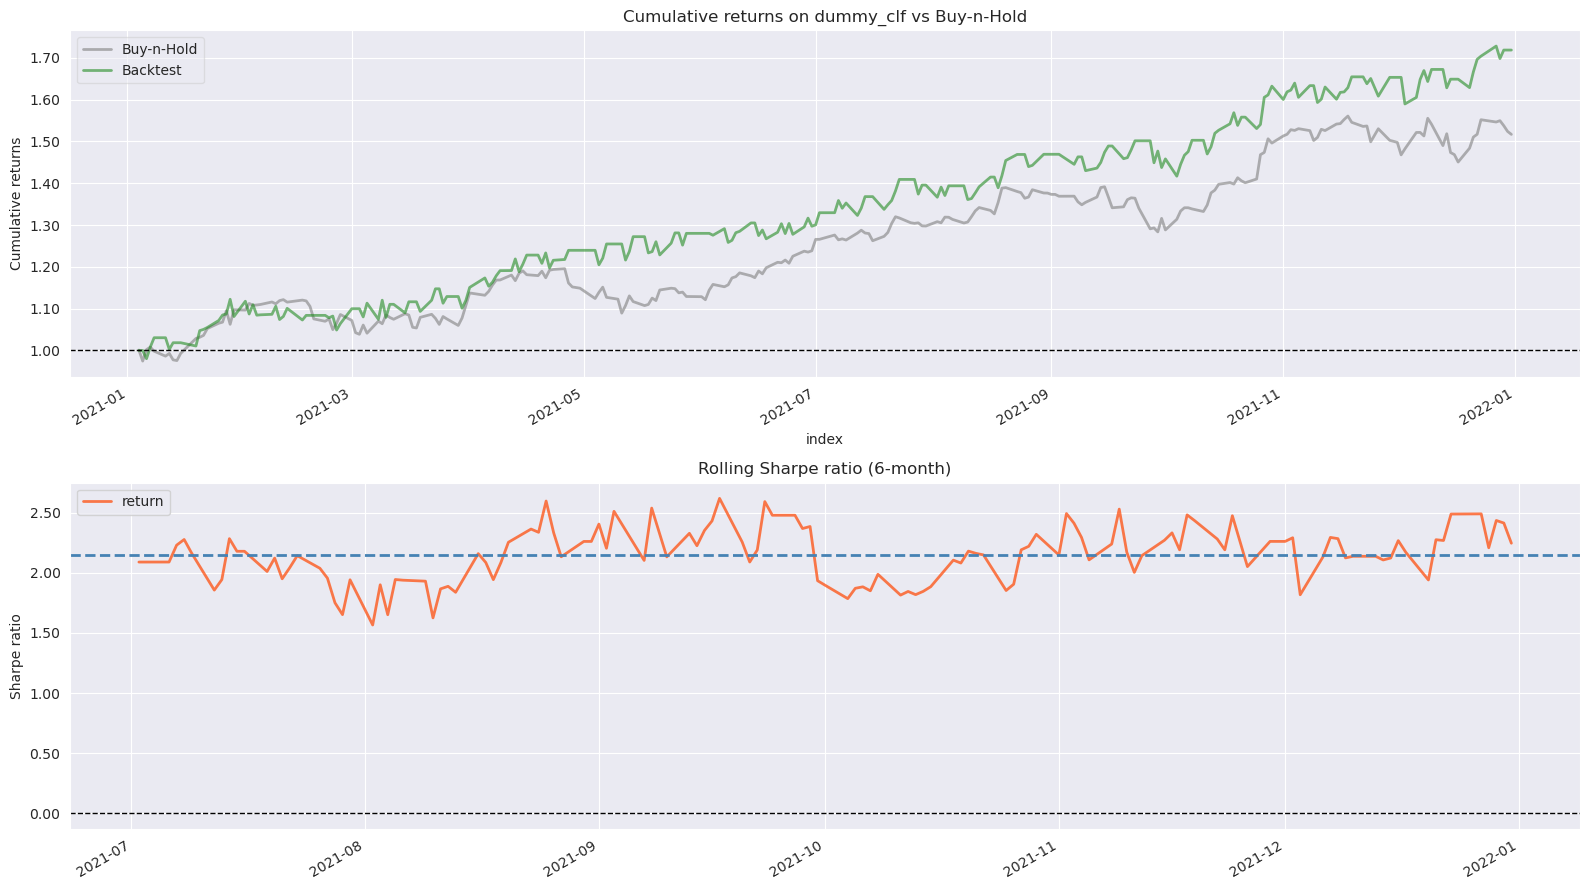

In [113]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_returns(returns=returns,
                        factor_returns=passive_rets,
                        ax=axes[0], 
                        title='Cumulative returns on {} vs {}'
                        .format(strat, passive_rets.name))

pf.plot_rolling_sharpe(returns=returns, ax=axes[1])


plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_passive".format(tick,strat))

In [86]:
pf.show_perf_stats(returns=returns, positions=positions, transactions=transactions)

Start date,2021-01-04
End date,2021-12-31
Total months,12
,Backtest
Annual return,71.843%
Cumulative returns,71.843%
Annual volatility,26.83%
Sharpe ratio,2.15
Calmar ratio,10.97
Stability,0.98
Max drawdown,-6.551%


## Save results

In [100]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

#export
returns.to_hdf('backtrader.h5', 'pyfolio/{}/{}/returns'.format(tick,strat))
positions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/positions'.format(tick,strat))
transactions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/transactions/'.format(tick,strat))
gross_lev.to_hdf('backtrader.h5', 'pyfolio/{}/{}/gross_lev'.format(tick,strat))

##  pyfolio analysis

In [101]:
benchmark = pd.read_hdf('./assets.h5', 'yfinance/index/vtsax')

In [102]:
benchmark.index.name = 'datetime'
benchmark_rets = benchmark['Adj Close'].pct_change()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'VTSAX'
benchmark_rets.head(2)

datetime
2021-01-04 00:00:00+00:00   -0.014672
2021-01-05 00:00:00+00:00    0.008463
Name: VTSAX, dtype: float64

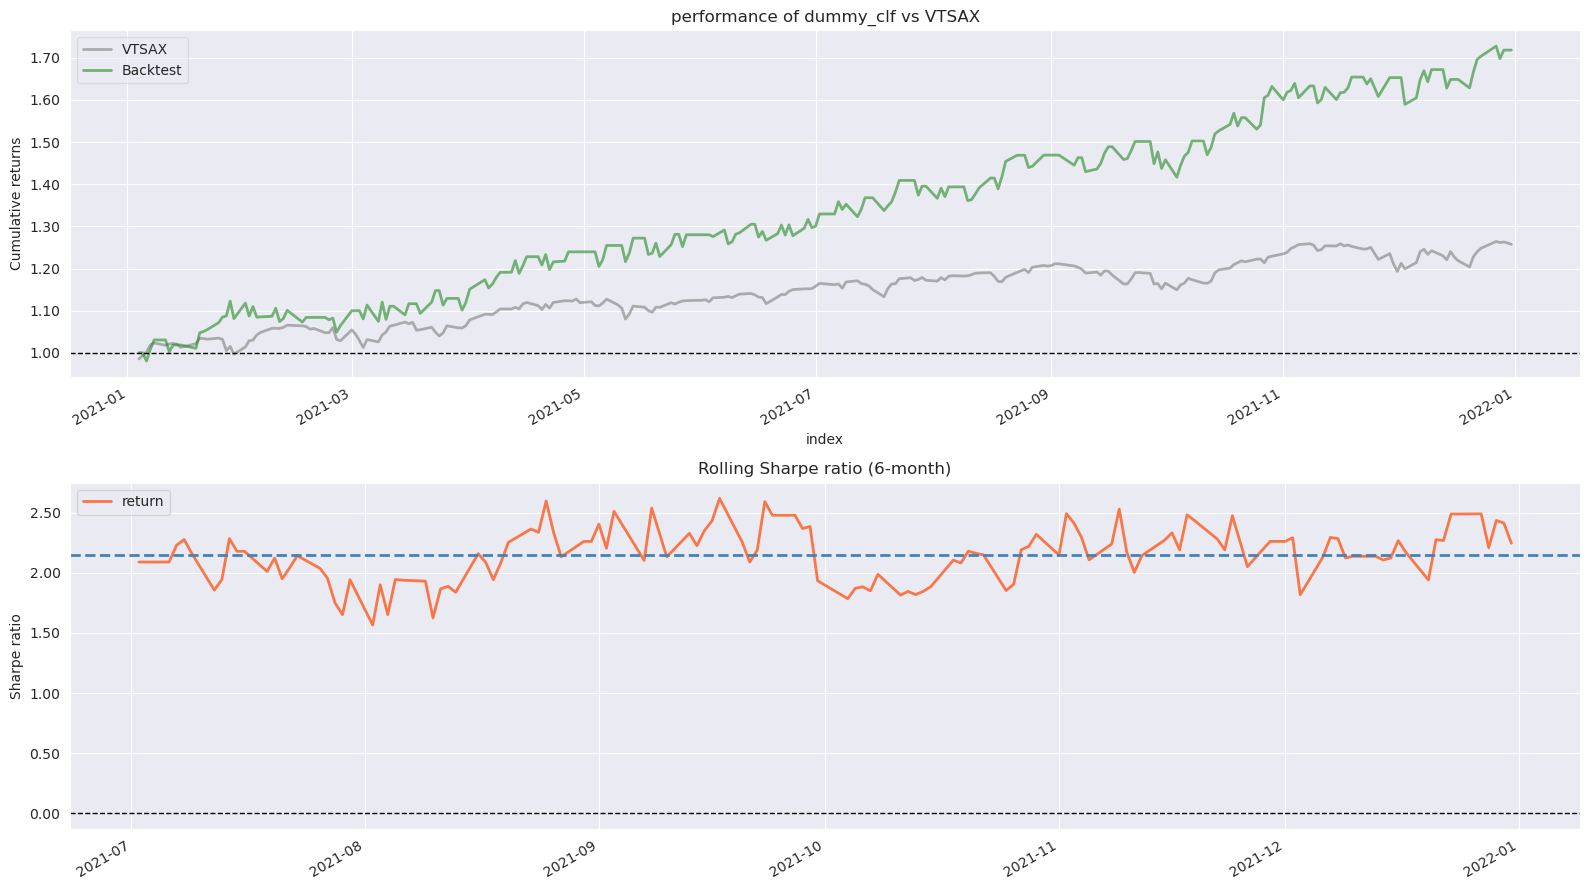

In [111]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], 
                        title='performance of {} vs {}'
                       .format(strat,benchmark_rets.name))
axes[1].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

plt.grid(True)
plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_{}".format(tick,strat,benchmark_rets.name))

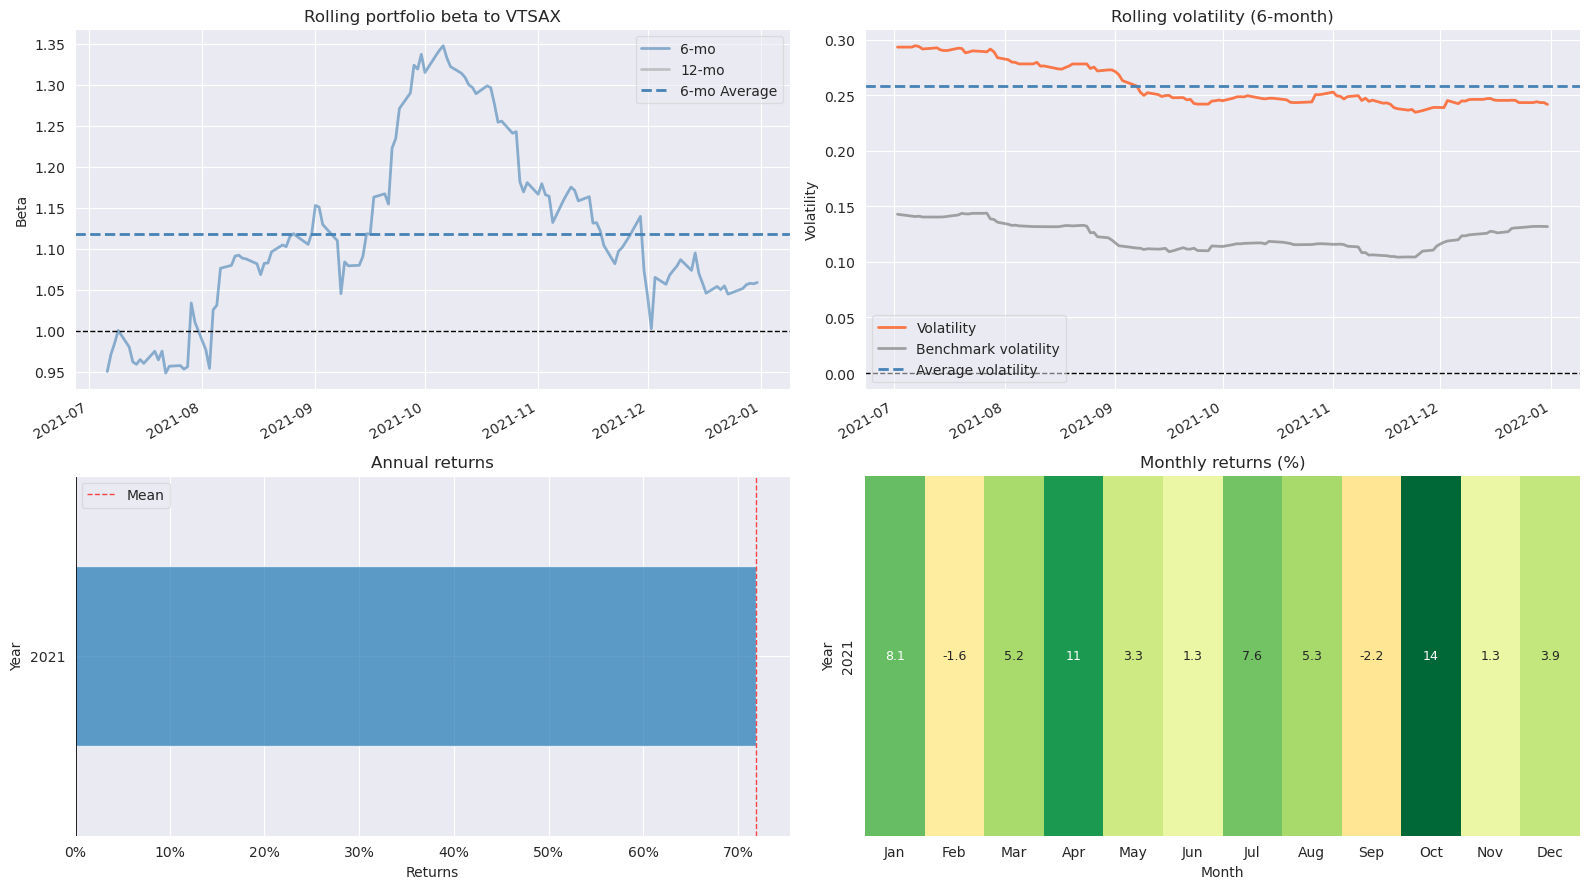

In [112]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
pf.plot_annual_returns(returns=returns, ax=axes[2])
pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

plt.tight_layout()
save_fig("pyfolio_results _{}_{}".format(tick,strat,benchmark_rets.name))